In [1]:
import grpc

from minecraft_pb2 import *
import minecraft_pb2_grpc

import matplotlib.pyplot as plt
import numpy as np
import torch
import diffusers
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from diffusers import UNet2DModel, DDPMScheduler

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
channel = grpc.insecure_channel('localhost:5001')
client = minecraft_pb2_grpc.MinecraftServiceStub(channel)

In [3]:
#Create an image
# Spawn associated blocks in MC


# Create list or dict of blocks
# from dict use size for categorical values
# also add direction
# do argmax for what blocks to spawn.

blockList = [
    REDSTONE_TORCH, REDSTONE_WIRE, UNPOWERED_REPEATER, UNPOWERED_COMPARATOR, PISTON, COBBLESTONE, AIR, STICKY_PISTON, SLIME,
]

orientationList = [
    NORTH, WEST, SOUTH, EAST, UP, DOWN
]


channels = len(blockList) + len(orientationList)

image_size = 32
image = torch.randn((1, channels, image_size, image_size))

In [4]:
def TensorToBlocks(input, blockLen, offset):
    blockChannels = input[:, :blockLen, :, :]
    orientationChannels = input[:, blockLen:, :, :]
    
    blockIds = blockChannels.argmax(dim=1).squeeze()
    dirs = orientationChannels.argmax(dim=1).squeeze()

    blocks = []
    for i in range(blockIds.shape[0]):
        for j in range(blockIds.shape[1]):
            blocks.append(
                Block(
                    position=Point(x=i + offset['x'], y=offset['y'], z=j + offset['z']), 
                    type=blockList[blockIds[i, j]], 
                    orientation=orientationList[dirs[i, j]]))
    return Blocks(blocks=blocks)

offset = {'x': 10, 'y': 4, 'z': 5}
outBlocks = TensorToBlocks(image, len(blockList), offset)


In [5]:
# Spawn output
client.spawnBlocks(outBlocks)

In [6]:
# clear output
# ADD +- small amount
# Add code to fix ground

client.fillCube(FillCubeRequest(
    cube=Cube(
        min=Point(x=offset['x'], y=offset['y'], z=offset['z']),
        max=Point(x=offset['x'] + image_size, y=offset['y'], z=offset['z'] + image_size)
    ),
    type=AIR
))

In [ ]:
#add code to copy build / get sample
# needs read code
# translate code
# save sample code

In [7]:
#outBlocks = TensorToBlocks(image, len(blockList), offset)
def BlockToTensor(blocks, offset, imageSize, blockList, orientationList):
      channels = len(blockList) + len(orientationList)
      image = torch.zeros((channels, imageSize, imageSize))
      for block in blocks.blocks:
            if block.type not in blockList: 
                  continue # In case of things like PISTON_HEAD, just skip it
            image[
                  blockList.index(block.type), 
                  block.position.x - offset['x'], 
                  block.position.z - offset['z']] = 1 
            image[
                  len(blockList) + orientationList.index(block.orientation), 
                  block.position.x - offset['x'], 
                  block.position.z - offset['z']] = 1
      return image.unsqueeze(0)

In [8]:
inBlocks = BlockToTensor(outBlocks, offset, image_size, blockList, orientationList)

In [9]:
# visualize tensor
# collapse block type with argmax and discard orientation.

def VisualizeTensor(input, orientationLen):
    blockChannels = input[:, :-orientationLen, :, :]
    blockType = torch.argmax(blockChannels, dim=1).squeeze()

    plt.imshow(blockType.cpu().numpy())

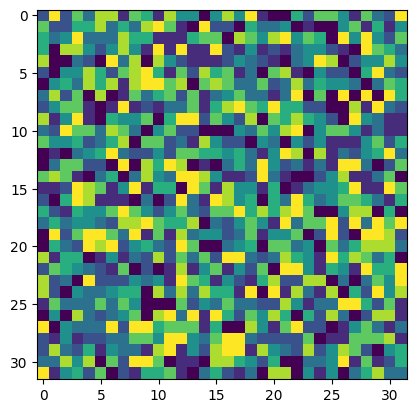

In [10]:
VisualizeTensor(image, 6)

In [11]:
# Gets cube with ysize = 1
def getCube(minPoint, size):
    return Cube(
        min=Point(x=minPoint['x'], y=minPoint['y'], z=minPoint['z']),
        max=Point(x=minPoint['x'] + size - 1, y=minPoint['y'], z=minPoint['z'] + size - 1)
    )

blocks = client.readCube(
    getCube(offset, image_size)
)

In [12]:
readBlocks = BlockToTensor(blocks, offset, image_size, blockList, orientationList)

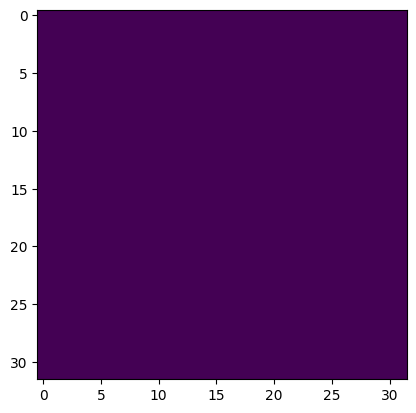

In [13]:
VisualizeTensor(readBlocks, 6)